In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Multivariate Time Series Prediction of energy consumption for a household by implementing Recursive Feature Elimination & LSTM-Keras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
dateparse = lambda dates:pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv('/content/drive/My Drive/MyGoogleCollab/EnergyConsumption/energydata_complete.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)

**Data Set Information:** (UCI)

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters). 


**Attribute Information:**

date time year-month-day hour:minute:second 

Appliances, energy use in Wh 

lights, energy use of light fixtures in the house in Wh 

T1, Temperature in kitchen area, in Celsius 

RH_1, Humidity in kitchen area, in % 

T2, Temperature in living room area, in Celsius 

RH_2, Humidity in living room area, in % 

T3, Temperature in laundry room area 

RH_3, Humidity in laundry room area, in % 

T4, Temperature in office room, in Celsius 

RH_4, Humidity in office room, in % 

T5, Temperature in bathroom, in Celsius 

RH_5, Humidity in bathroom, in % 

T6, Temperature outside the building (north side), in Celsius 

RH_6, Humidity outside the building (north side), in % 

T7, Temperature in ironing room , in Celsius 

RH_7, Humidity in ironing room, in % 

T8, Temperature in teenager room 2, in Celsius 

RH_8, Humidity in teenager room 2, in % 

T9, Temperature in parents room, in Celsius 

RH_9, Humidity in parents room, in % 

To, Temperature outside (from Chievres weather station), in Celsius 

Pressure (from Chievres weather station), in mm Hg 

RH_out, Humidity outside (from Chievres weather station), in % 

Wind speed (from Chievres weather station), in m/s 

Visibility (from Chievres weather station), in km 

Tdewpoint (from Chievres weather station), Â°C 

rv1, Random variable 1, nondimensional 

rv2, Random variable 2, nondimensional 


In [4]:
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
Appliances     19735 non-null int64
lights         19735 non-null int64
T1             19735 non-null float64
RH_1           19735 non-null float64
T2             19735 non-null float64
RH_2           19735 non-null float64
T3             19735 non-null float64
RH_3           19735 non-null float64
T4             19735 non-null float64
RH_4           19735 non-null float64
T5             19735 non-null float64
RH_5           19735 non-null float64
T6             19735 non-null float64
RH_6           19735 non-null float64
T7             19735 non-null float64
RH_7           19735 non-null float64
T8             19735 non-null float64
RH_8           19735 non-null float64
T9             19735 non-null float64
RH_9           19735 non-null float64
T_out          19735 non-null float64
Press_mm_hg    19735 non-null float64
RH_out         19735 non

In [5]:
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


**Plotting part of the time series.**

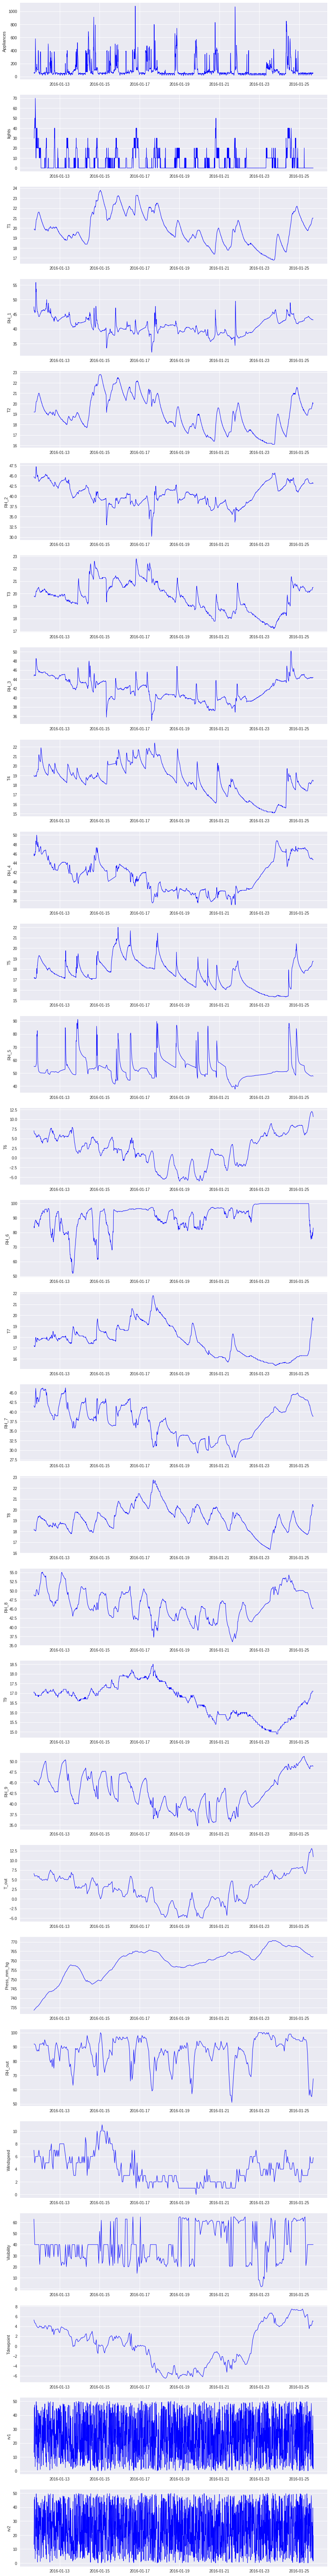

In [8]:
fig, axs = plt.subplots(nrows=len(data.columns), ncols=1, sharex=False, figsize=(14,120))
i=0
for col in data.columns:
  line = axs[i].plot(data[col][:2016])
  plt.setp(line, linewidth =1, color='b')
  axs[i].set_ylabel(col)
  i=i+1 

plt.show()

**Variables Distribution as corresponding to Day or Night.**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


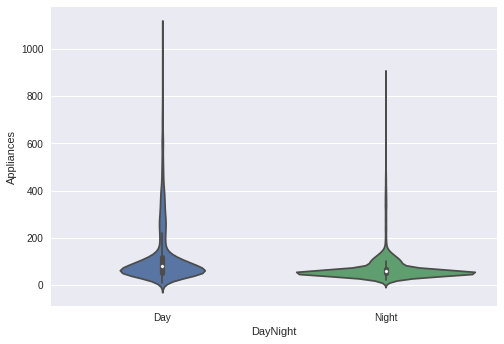

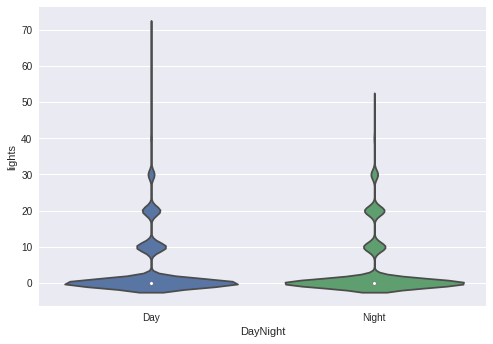

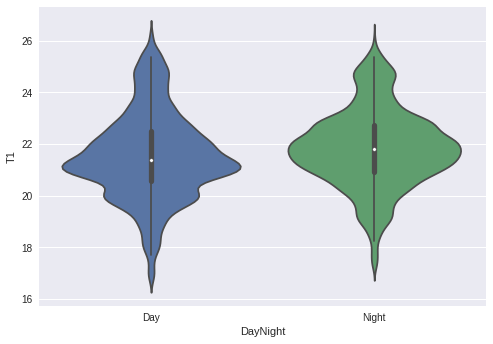

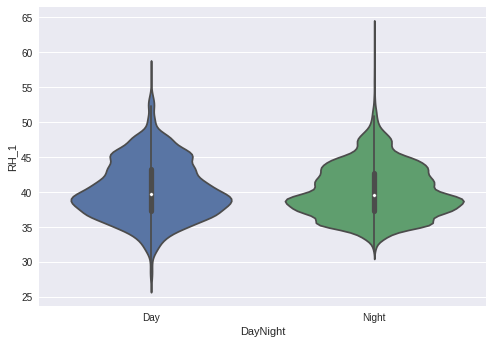

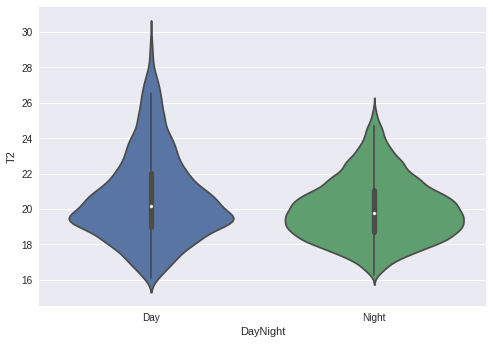

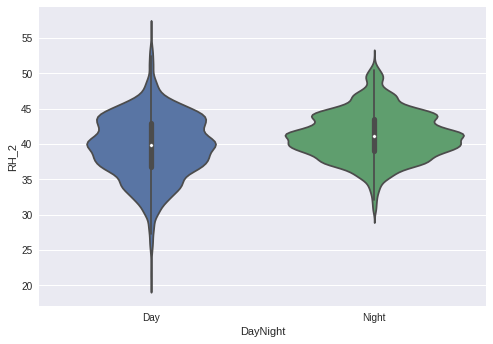

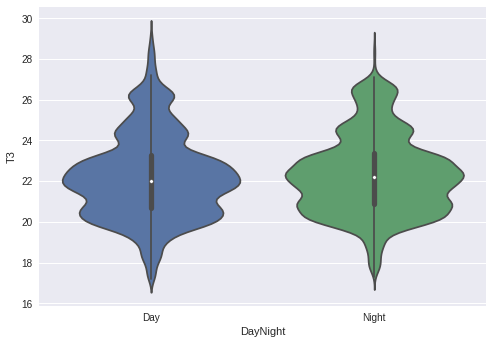

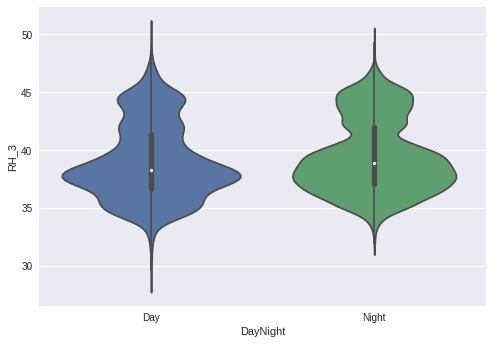

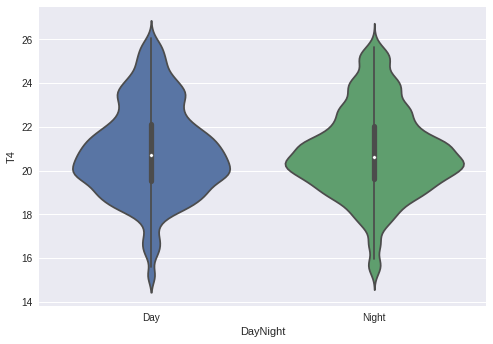

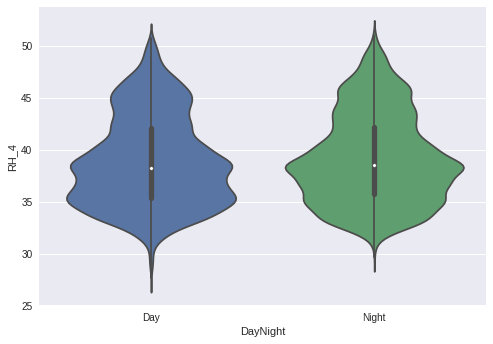

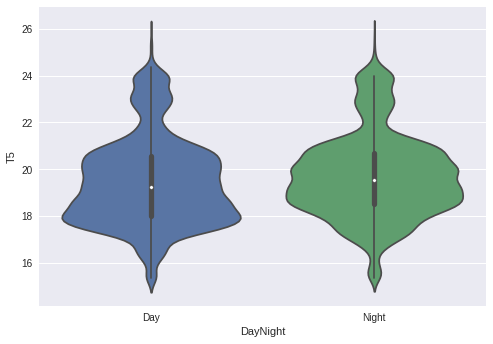

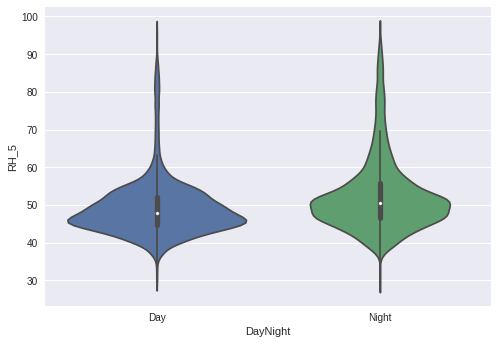

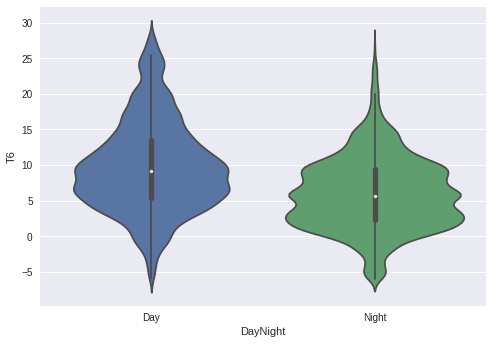

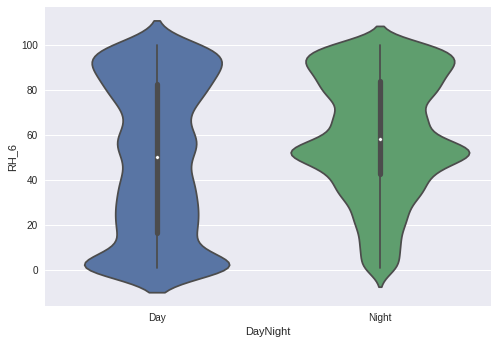

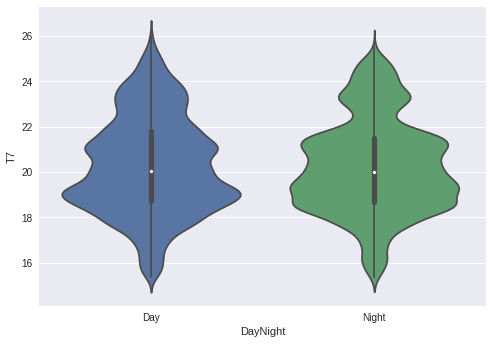

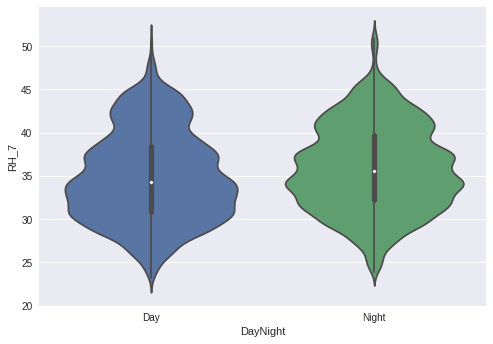

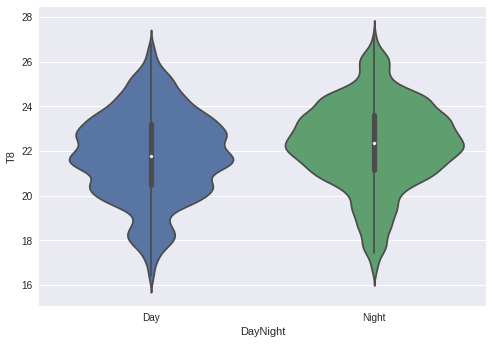

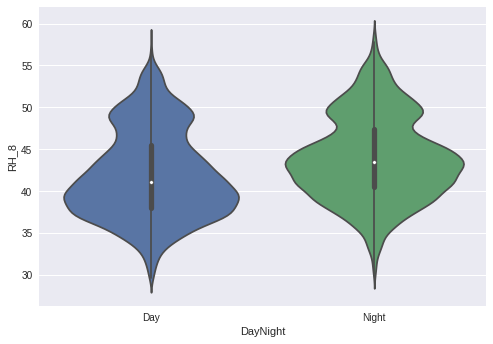

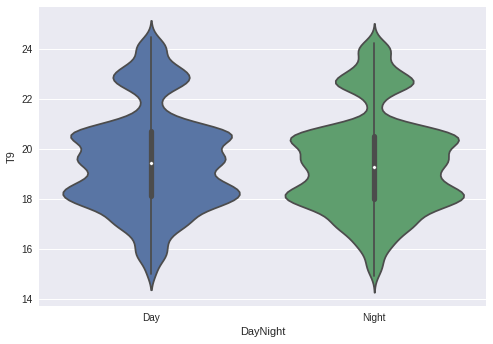

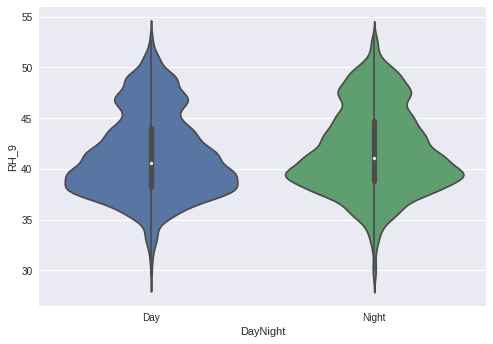

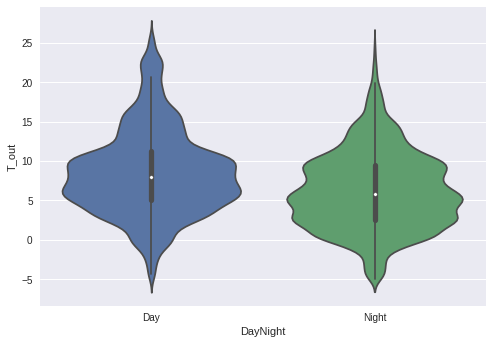

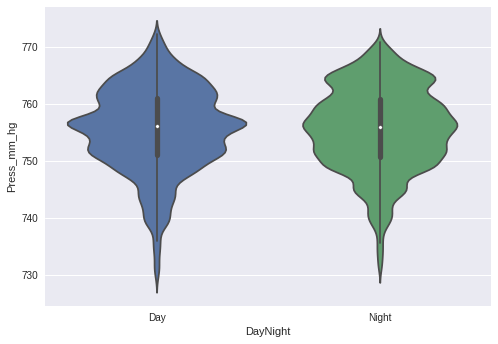

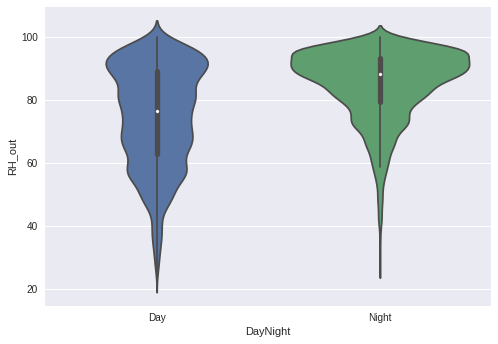

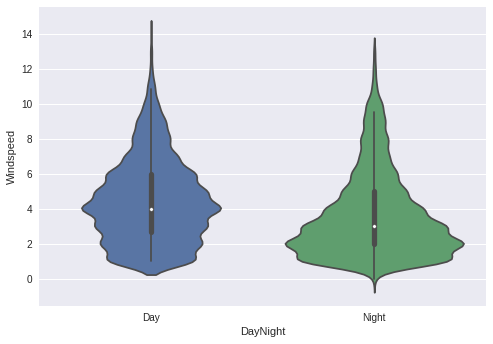

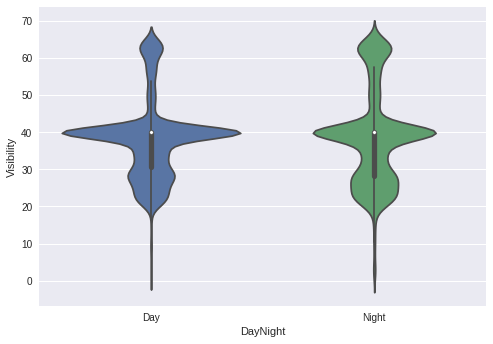

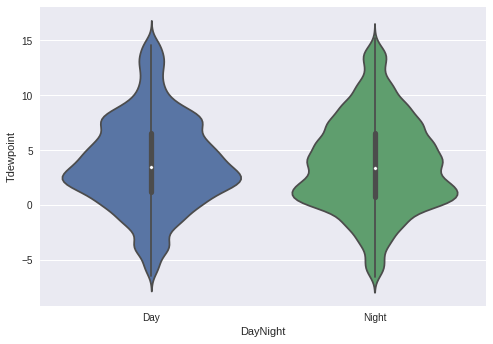

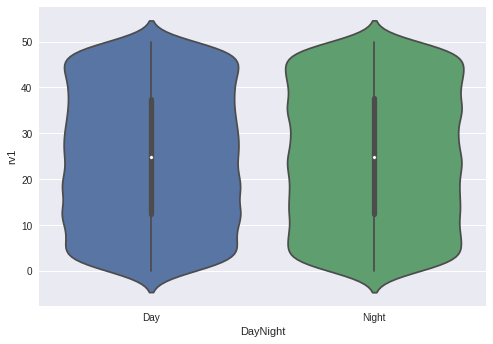

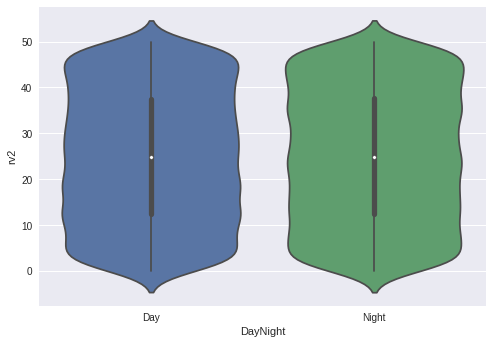

In [15]:
datetime = pd.to_datetime(data.index,)
data['DateTime'] = datetime.values
data['hour'] = data['DateTime'].apply(lambda x: x.hour)
data['DayNight'] = data['hour'].apply(lambda x: 'Day' if (x >= 7 and x<= 18) else 'Night') 

colmns_prplt = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint','hour', 'DayNight']

for colidx in range(len(data.columns)-3):
  sns.violinplot(x="DayNight", y=data[data.columns[colidx]], data= data, split= True)
  plt.show()

#sns.violinplot(x = data['DayNight'],y= data['Windspeed'], data= data, split= False)

In [0]:
data_model = data.drop(columns=['DateTime', 'hour', 'DayNight'])

**Feature Correlations Heatmap for all features.**

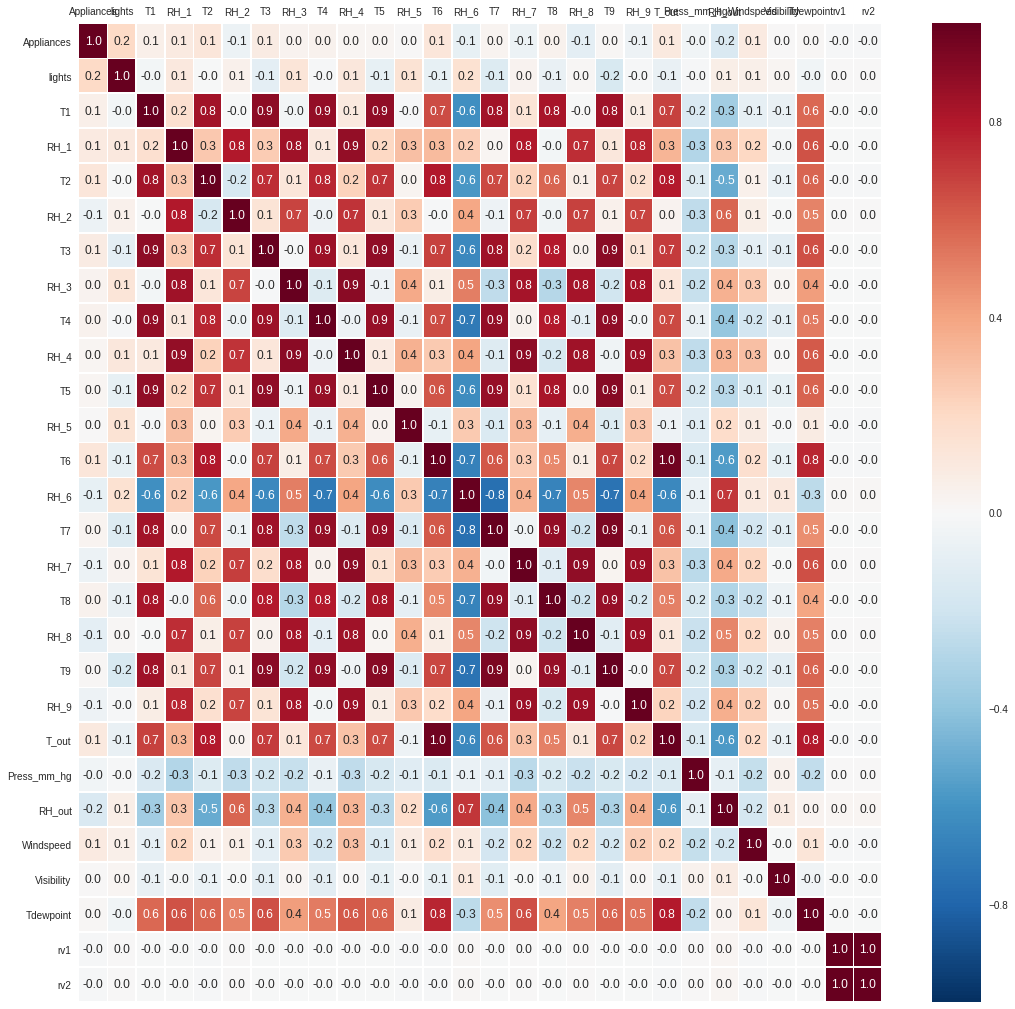

In [18]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data_model.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.xaxis.set_ticks_position('top')

**Dropping highly correlated features to reduce the dimension.**

In [0]:
drop_fts = ['T2', 'T3','T4','T5', 'T7','T8', 'T9', 'RH_2','RH_3', 'RH_4', 'RH_7','RH_9']
data_ucor_fts = data_model.drop(drop_fts,axis = 1 )   

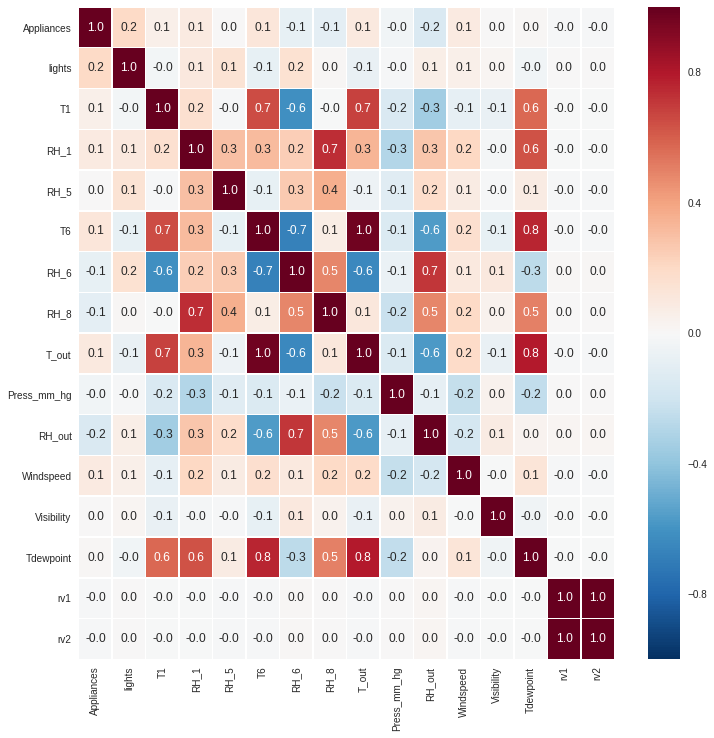

In [20]:
f,ax = plt.subplots(figsize=(12,12))
sns.heatmap(data_ucor_fts.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

**Implementing Recursive Feature Elimination-cross validation to eliminate further features.**

In [23]:
import warnings
warnings.filterwarnings("ignore")

X =data_ucor_fts.iloc[:, 1:]
y = data["Appliances"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf_rf = RandomForestRegressor() 
rfecv = RFECV(estimator=clf_rf, step=1, cv=5,scoring='neg_mean_squared_error', verbose=0)   
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 9
Best features : Index(['T1', 'RH_1', 'RH_5', 'T6', 'RH_6', 'RH_8', 'Press_mm_hg', 'RH_out',
       'Tdewpoint'],
      dtype='object')


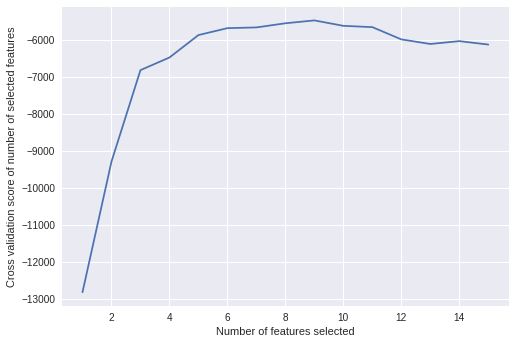

In [29]:
data_ts= data_ucor_fts[['Appliances','T1', 'RH_1', 'RH_5', 'T6', 'RH_6', 'RH_8', 'Press_mm_hg', 'RH_out','Tdewpoint']]

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

**Augmented Dickey-Fuller test for Stationarity Check**

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

* p -value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [30]:
import statsmodels.api as sm
for i in data_ts.columns:
  result = sm.tsa.stattools.adfuller(data_ts[i])
  print("ADF Statistics for %s: %f" %(i, result[0]))
  print("p value for %s: %f" %(i,result[1]))
  print("Critical Values")
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistics for Appliances: -21.616378
p value for Appliances: 0.000000
Critical Values
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistics for T1: -5.737394
p value for T1: 0.000001
Critical Values
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistics for RH_1: -5.224069
p value for RH_1: 0.000008
Critical Values
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistics for RH_5: -19.975427
p value for RH_5: 0.000000
Critical Values
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistics for T6: -9.581727
p value for T6: 0.000000
Critical Values
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistics for RH_6: -7.006972
p value for RH_6: 0.000000
Critical Values
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistics for RH_8: -10.176925
p value for RH_8: 0.000000
Critical Values
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistics for Press_mm_hg: -5.717286
p value for Press_mm_hg: 0.000001
Critical Values
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistics for RH_out: -15.609493
p value for RH_out: 0

Convert the multivariate time series to supervised learning problem by shifting the feature columns.

In [33]:
#Source: machinelearningmastery.com

from sklearn.preprocessing import MinMaxScaler
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

values = data_ts.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.046729   0.327349   0.566187   0.381691   0.381070   0.841827   
2   0.046729   0.327349   0.541326   0.381691   0.375443   0.839872   
3   0.037383   0.327349   0.530502   0.380037   0.367487   0.830704   
4   0.037383   0.327349   0.524080   0.380037   0.363800   0.833401   
5   0.046729   0.327349   0.531419   0.380037   0.361859   0.848264   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
1   0.661412   0.097675   0.894737    0.538462  0.046729  
2   0.660155   0.100000   0.894737    0.533937  0.037383  
3   0.655586   0.102327   0.894737    0.529412  0.037383  
4   0.650788   0.104652   0.894737    0.524887  0.046729  
5   0.650788   0.106977   0.894737    0.520362  0.037383  


In [34]:
values = reframed.values
n_train_10min_intervals = 6*24*60
train = values[:n_train_10min_intervals, :]
test = values[n_train_10min_intervals:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8640, 1, 10) (8640,) (11094, 1, 10) (11094,)


**Define & Run the Keras-LSTM Model**

In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Using TensorFlow backend.


Train on 8640 samples, validate on 11094 samples
Epoch 1/50
 - 1s - loss: 0.0523 - val_loss: 0.0409
Epoch 2/50
 - 0s - loss: 0.0439 - val_loss: 0.0421
Epoch 3/50
 - 0s - loss: 0.0383 - val_loss: 0.0385
Epoch 4/50
 - 0s - loss: 0.0336 - val_loss: 0.0297
Epoch 5/50
 - 0s - loss: 0.0308 - val_loss: 0.0279
Epoch 6/50
 - 0s - loss: 0.0302 - val_loss: 0.0276
Epoch 7/50
 - 0s - loss: 0.0298 - val_loss: 0.0271
Epoch 8/50
 - 0s - loss: 0.0296 - val_loss: 0.0272
Epoch 9/50
 - 0s - loss: 0.0291 - val_loss: 0.0265
Epoch 10/50
 - 0s - loss: 0.0288 - val_loss: 0.0254
Epoch 11/50
 - 0s - loss: 0.0288 - val_loss: 0.0251
Epoch 12/50
 - 0s - loss: 0.0290 - val_loss: 0.0249
Epoch 13/50
 - 0s - loss: 0.0288 - val_loss: 0.0250
Epoch 14/50
 - 0s - loss: 0.0289 - val_loss: 0.0248
Epoch 15/50
 - 0s - loss: 0.0288 - val_loss: 0.0248
Epoch 16/50
 - 0s - loss: 0.0289 - val_loss: 0.0248
Epoch 17/50
 - 0s - loss: 0.0289 - val_loss: 0.0248
Epoch 18/50
 - 0s - loss: 0.0288 - val_loss: 0.0248
Epoch 19/50
 - 0s - loss

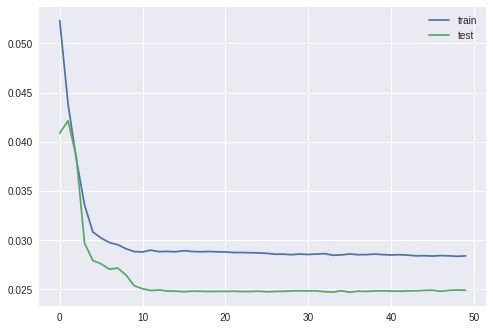

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()